<a href="https://colab.research.google.com/github/Moorea-AI/ANALITICA3/blob/main/d_modelos2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
################################################################
#               PRIMER TRABAJO PARA LA MATERIA:                #
#                 APLICACIONES DE LA ANALITICA                 #
#                  MÓDULO DE RECURSOS HUMANOS                  #
#                              POR:                            #
#                                                              #
#                    AURA LUZ MORENO - MOOREA                  #
#                       ALEJANDRA AGUIRRE                      #
#                                                              #
#                    UNIVERSIDAD DE ANTIOQUIA                  #
################################################################

In [57]:
###importar librerias
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error,  mean_absolute_error, mean_absolute_percentage_error, r2_score, classification_report
import math
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
import sys
import sqlite3 as sql #### para bases de datos sql
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from imblearn.combine import SMOTETomek
from collections import Counter
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.svm import SVC

##Importación de datos

In [58]:
sys.path.append('/content/drive/MyDrive')

In [59]:
#conectamos drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
## conectamos las funciones
import a_funciones as funciones

In [61]:
### se genera la URL para conectarse a la base de datos
BD = 'https://raw.githubusercontent.com/Moorea-AI/ANALITICA3/main/databases/BD.csv'

In [62]:
df=pd.read_csv(BD)

In [63]:
df.info() ### mostramos para ver cuales variables son categoricas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35280 entries, 0 to 35279
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   employeeid               35280 non-null  int64  
 1   environmentsatisfaction  35280 non-null  float64
 2   jobsatisfaction          35280 non-null  float64
 3   worklifebalance          35280 non-null  float64
 4   datesurvey               35280 non-null  object 
 5   jobinvolvement           35280 non-null  int64  
 6   performancerating        35280 non-null  int64  
 7   surveydate               35280 non-null  object 
 8   attrition                35280 non-null  object 
 9   retirementdate           35280 non-null  object 
 10  retirementtype           35280 non-null  object 
 11  resignationreason        35280 non-null  object 
 12  age                      35280 non-null  int64  
 13  businesstravel           35280 non-null  object 
 14  department            

In [64]:
## se eliminan algunas filas que no son necesarias para la implementación del modelo
df= df.drop(['datesurvey', 'surveydate', 'infodate', 'employeeid', 'retirementdate', 'infodate','retirementdate','retirementtype'],  axis=1)

In [65]:
##crreamos una lista con las variables categoricas
list_dummies = ['resignationreason', 'businesstravel', 'department', 'educationfield', 'jobrole', 'maritalstatus']


In [66]:
df_dummies=pd.get_dummies(df,columns=list_dummies)
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35280 entries, 0 to 35279
Data columns (total 47 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   environmentsatisfaction            35280 non-null  float64
 1   jobsatisfaction                    35280 non-null  float64
 2   worklifebalance                    35280 non-null  float64
 3   jobinvolvement                     35280 non-null  int64  
 4   performancerating                  35280 non-null  int64  
 5   attrition                          35280 non-null  object 
 6   age                                35280 non-null  int64  
 7   distancefromhome                   35280 non-null  int64  
 8   education                          35280 non-null  int64  
 9   gender                             35280 non-null  object 
 10  joblevel                           35280 non-null  int64  
 11  monthlyincome                      35280 non-null  int

In [67]:
print(df_dummies.attrition.unique())


['No' 'Yes']


In [68]:
### debido a la alta correlación que se encontro en el análisis exploratorio se elimina las siguientes variables:
df_d = df_dummies.drop(['age', 'yearsatcompany', 'yearssincelastpromotion', 'gender'],  axis=1)

In [69]:
###lista con variables numericas
ce=["distancefromhome","education","joblevel","monthlyincome","percentsalaryhike","stockoptionlevel","jobinvolvement"]


In [70]:
### creamos una función que permita normalizar la variable objetivo
def cambiar_si_no_a_numeros(columna):
    return columna.map({'Yes': 1, 'No': 0})

# Supongamos que tienes un DataFrame llamado df y quieres cambiar los valores de la columna 'columna_si_no'
df_d['attrition'] = cambiar_si_no_a_numeros(df_d['attrition'])

In [71]:
y=df_d["attrition"]
x=df_d.drop(["attrition"],axis=1)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.5)

df_d[ce]=df_d[ce].astype(float)
columnasfloat=list(df_d.select_dtypes("float64").columns)
pipeline=ColumnTransformer([("num", StandardScaler(),columnasfloat)],remainder='passthrough')

X_train_std = pipeline.fit_transform(X_train)
X_test_std = pipeline.transform(X_test)

##Modelo base

Selección de varianbles con el metódo Lasso

In [72]:
sel_ = SelectFromModel(Lasso(alpha = 0.001, max_iter=10000), max_features=30) #entre mas aumente el parametro de serializacion, mas variables van atender a 0
sel_.fit(X_train_std, y_train)
print(sel_.estimator_.coef_)
#Obtener variables seleccionadas
X_new = sel_.get_support()#descarta los coeficientes mas cercanos a 0
X_train_base1 = X_train_std[:,X_new]
X_test_base1= X_test_std[:,X_new]
X_train.iloc[:,X_new]

[-6.35025642e-03 -3.79568427e-03 -7.22542414e-05  0.00000000e+00
 -7.87368964e-04 -0.00000000e+00 -3.44432662e-04 -3.28896487e-03
  0.00000000e+00  2.34775861e-03 -1.54422303e-03 -7.59114638e-03
  0.00000000e+00  0.00000000e+00 -9.64650511e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  8.82966584e-03
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -1.70926417e-03 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.22476341e-03  0.00000000e+00 -1.49953165e-04
 -0.00000000e+00  1.14888906e-02]


,environmentsatisfaction,jobsatisfaction,worklifebalance,performancerating,education,joblevel,numcompaniesworked,percentsalaryhike,stockoptionlevel,resignationreason_Activo,businesstravel_Travel_Frequently,educationfield_Technical Degree,jobrole_Sales Executive,maritalstatus_Divorced,maritalstatus_Single
25433,3.0,3.0,3.0,3,3,1,7.0,11,1,1,0,0,0,0,1
27370,3.0,4.0,2.0,3,4,3,3.0,11,1,1,0,0,0,0,1
7827,1.0,2.0,1.0,3,3,2,5.0,11,1,0,0,0,0,0,0
5540,3.0,1.0,3.0,3,3,1,1.0,18,1,1,0,0,1,1,0
29427,1.0,3.0,1.0,4,2,2,2.0,20,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11536,4.0,3.0,4.0,4,2,4,1.0,23,0,1,1,0,0,1,0
28050,3.0,4.0,2.0,3,5,2,5.0,15,1,0,0,0,0,1,0
9665,4.0,3.0,3.0,3,2,1,2.0,12,1,0,1,0,0,0,0
25250,4.0,4.0,1.0,3,4,4,0.0,12,0,1,0,0,0,0,0


In [73]:

X_train.iloc[:,X_new].columns

Index(['environmentsatisfaction', 'jobsatisfaction', 'worklifebalance',
       'performancerating', 'education', 'joblevel', 'numcompaniesworked',
       'percentsalaryhike', 'stockoptionlevel', 'resignationreason_Activo',
       'businesstravel_Travel_Frequently', 'educationfield_Technical Degree',
       'jobrole_Sales Executive', 'maritalstatus_Divorced',
       'maritalstatus_Single'],
      dtype='object')

##Metódo Wraper

In [74]:
# Función recursiva de selección de características
def recursive_feature_selection(X,y,model,k):
  rfe = RFE(model, n_features_to_select=k, step=1)
  fit = rfe.fit(X, y)
  X_new = fit.support_
  print("Num Features: %s" % (fit.n_features_))
  print("Selected Features: %s" % (fit.support_))
  print("Feature Ranking: %s" % (fit.ranking_))
  return X_new

In [75]:
# Establecer Estimador
model = LogisticRegression(max_iter=10000)
# Obtener columnas seleciconadas - (30 caracteristicas)
X_new_class = recursive_feature_selection(X_train_std, y_train, model, 16)

# Nuevo conjunto de datos
X_train_base2 = X_train_std[:,X_new_class]
X_test_base2= X_test_std[:,X_new_class]
X_train.iloc[:,X_new_class]

Num Features: 16
Selected Features: [ True False False False False False False False False False False  True
 False False  True  True  True  True False  True False  True False False
  True False False False  True  True False False False False  True  True
 False  True False  True False  True]
Feature Ranking: [ 1  3 23 27 14 24 16  4 18 19 13  1  2 26  1  1  1  1  6  1  7  1  9 10
  1 22 21  8  1  1 20 17 11  5  1  1 25  1 12  1 15  1]


,environmentsatisfaction,stockoptionlevel,resignationreason_Activo,resignationreason_Others,resignationreason_Salary,resignationreason_Stress,businesstravel_Travel_Frequently,department_Human Resources,educationfield_Human Resources,educationfield_Other,educationfield_Technical Degree,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Sales Executive,maritalstatus_Divorced,maritalstatus_Single
25433,3.0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1
27370,3.0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1
7827,1.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5540,3.0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0
29427,1.0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11536,4.0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0
28050,3.0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0
9665,4.0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0
25250,4.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


###Modelo de regresión logística

In [76]:
# Entrenamiento del modelo
modelo = LogisticRegression(random_state=142, class_weight='balanced')

# Ajustar el modelo a los datos
modelo.fit(X_train_base1, y_train)

# Desempeño en el entrenamiento
y_train_pred2 = modelo.predict(X_train_base1)

print('Exactitud en el entrenamiento: %.3f'  %accuracy_score(y_train, y_train_pred2) )

Exactitud en el entrenamiento: 0.985


In [77]:
y_pred = modelo.predict(X_test_base1)

# Exactitud en el conjunto de validación
print('Exactitud en la validacion: %.3f'  %accuracy_score(y_test, y_pred))

Exactitud en la validacion: 0.983


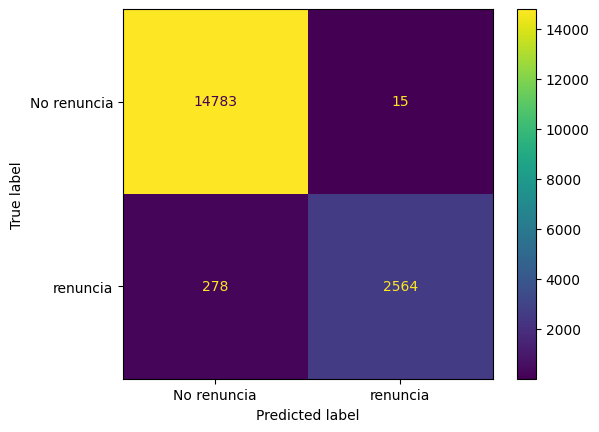

In [78]:
###Matriz de confusión
matriz= confusion_matrix(y_test, y_pred)
matriz_display = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=['No renuncia', 'renuncia'])
matriz_display.plot()
plt.show()

In [79]:
### metricas del modelo
tn, fp, fn, tp = matriz.ravel()

precision = tp / (tp + fp)
recall = tp / (tp + fn)
especificidad = tn / (fp + tn)
f1_score = 2*(precision*recall)/(precision+recall)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Especificidad: {especificidad}')
print(f'F1 score: {f1_score}')

Precision: 0.9941837921675067
Recall: 0.9021815622800844
Especificidad: 0.9989863495066901
F1 score: 0.9459509315624424


###Random Forest Classifier

In [90]:
## se crea el modelo
X_train_modelo3=X_train_base1
X_test_modelo3=X_test_base1

ranfor = RandomForestClassifier(class_weight="balanced",n_estimators = 150,criterion= 'gini', max_depth= 5,max_leaf_nodes = 10,n_jobs= -1,random_state = 123)
ranfor.fit(X_train_modelo3, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5, max_leaf_nodes=10,
                       n_estimators=150, n_jobs=-1, random_state=123)

In [81]:
###metricas
print ("Train - Accuracy :", metrics.accuracy_score(y_train, ranfor.predict(X_train_modelo3)))
print ("Train - classification report:\n", metrics.classification_report(y_train, ranfor.predict(X_train_modelo3)))
print ("Test - Accuracy :", metrics.accuracy_score(y_test, ranfor.predict(X_test_modelo3)))
print ("Test - classification report :", metrics.classification_report(y_test, ranfor.predict(X_test_modelo3)))

Train - Accuracy : 0.9866780045351474
Train - classification report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     14794
           1       1.00      0.92      0.96      2846

    accuracy                           0.99     17640
   macro avg       0.99      0.96      0.97     17640
weighted avg       0.99      0.99      0.99     17640

Test - Accuracy : 0.984750566893424
Test - classification report :               precision    recall  f1-score   support

           0       0.98      1.00      0.99     14798
           1       1.00      0.91      0.95      2842

    accuracy                           0.98     17640
   macro avg       0.99      0.95      0.97     17640
weighted avg       0.99      0.98      0.98     17640



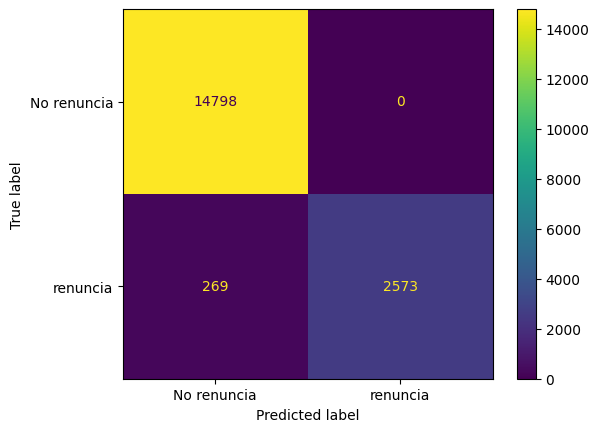

In [82]:
# Matriz de confusion
cm= confusion_matrix(y_test, ranfor.predict(X_test_modelo3))
# Visualización de la matriz de confusion
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['No renuncia', 'renuncia'])
cm_display.plot()
plt.show()

###Gradient Boosting Classifier

In [83]:
##se crea el modelo
X_train_modelo4= x_train_res[:, X_new]
X_test_modelo4 = X_test_std[:, X_new]
gboos = GradientBoostingClassifier( n_estimators = 100, learning_rate= 0.1, max_features = 4, random_state = 123)
gboos.fit(X_train_modelo4, y_train_res)

GradientBoostingClassifier(max_features=4, random_state=123)

In [84]:
##metricas
print ("Train - Accuracy :", metrics.accuracy_score(y_train_res, gboos.predict(X_train_modelo4)))
print ("Train - classification report:\n", metrics.classification_report(y_train_res, gboos.predict(X_train_modelo4)))
print ("Test - Accuracy :", metrics.accuracy_score(y_test, gboos.predict(X_test_modelo4)))
print ("Test - classification report :", metrics.classification_report(y_test, gboos.predict(X_test_modelo4)))

Train - Accuracy : 0.9758320394248295
Train - classification report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98     14813
           1       1.00      0.95      0.98     14813

    accuracy                           0.98     29626
   macro avg       0.98      0.98      0.98     29626
weighted avg       0.98      0.98      0.98     29626

Test - Accuracy : 0.9874149659863946
Test - classification report :               precision    recall  f1-score   support

           0       0.99      1.00      0.99     14798
           1       1.00      0.93      0.96      2842

    accuracy                           0.99     17640
   macro avg       0.99      0.96      0.98     17640
weighted avg       0.99      0.99      0.99     17640



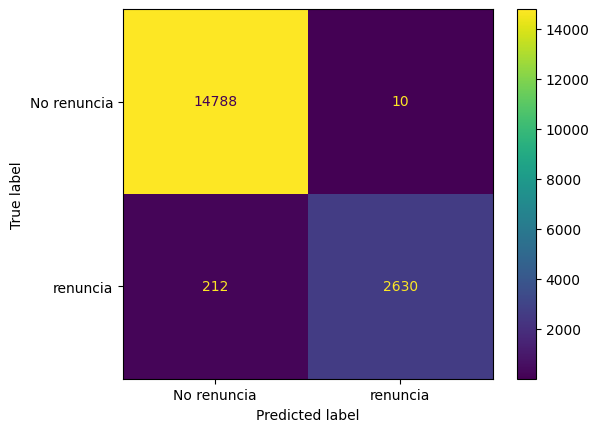

In [85]:
##matriz de confusióm
cm1= confusion_matrix(y_test, gboos.predict(X_test_modelo4))
cm1_display = ConfusionMatrixDisplay(confusion_matrix = cm1,  display_labels=['No renuncia', 'renuncia'])
cm1_display.plot()
plt.show()

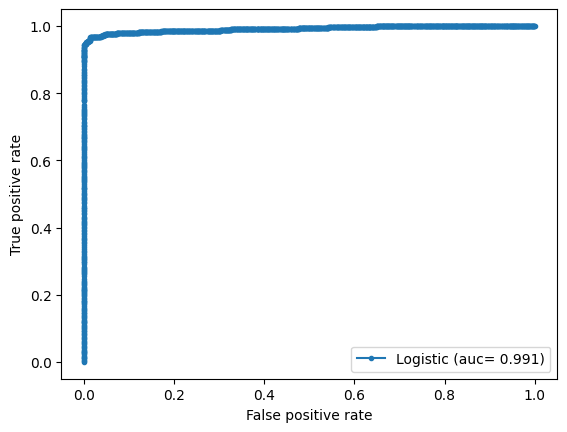

In [86]:
##se grafica curva de roc
y_pred = gboos.predict_proba(X_test_modelo4)[::,1]
fpr, tpr,_ =roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr,marker='.',label='Logistic (auc= %0.3f)'%auc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.show()

###Support Vector Machine

In [87]:
##se crea el modelo
X_train_modelo5=X_train_base1
X_test_modelo5=X_test_base1
svm_model = SVC(C = 1.5, kernel = 'linear', class_weight = 'balanced', max_iter =-1, random_state=123)
svm_model.fit(X_train_modelo5, y_train)

SVC(C=1.5, class_weight='balanced', kernel='linear', random_state=123)

In [88]:
##metricas
print ("Train - Accuracy :", metrics.accuracy_score(y_train, svm_model.predict(X_train_modelo5)))
print ("Train - classification report:\n", metrics.classification_report(y_train, svm_model.predict(X_train_modelo5)))
print ("Test - Accuracy :", metrics.accuracy_score(y_test, svm_model.predict(X_test_modelo5)))
print ("Test - classification report :", metrics.classification_report(y_test, svm_model.predict(X_test_modelo5)))

Train - Accuracy : 0.9851473922902494
Train - classification report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     14794
           1       1.00      0.91      0.95      2846

    accuracy                           0.99     17640
   macro avg       0.99      0.95      0.97     17640
weighted avg       0.99      0.99      0.98     17640

Test - Accuracy : 0.9831065759637189
Test - classification report :               precision    recall  f1-score   support

           0       0.98      1.00      0.99     14798
           1       1.00      0.90      0.94      2842

    accuracy                           0.98     17640
   macro avg       0.99      0.95      0.97     17640
weighted avg       0.98      0.98      0.98     17640



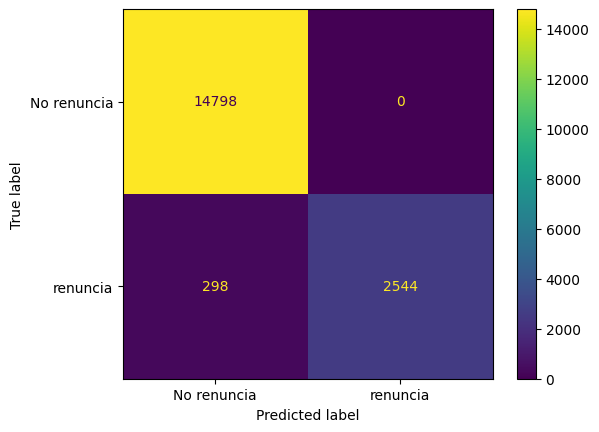

In [89]:
###matriz de confusión
cm1= confusion_matrix(y_test, svm_model.predict(X_test_modelo5))
cm1_display = ConfusionMatrixDisplay(confusion_matrix = cm1,  display_labels=['No renuncia', 'renuncia'])
cm1_display.plot()
plt.show()